# 循环神经网络的从零开始实现
:label:`sec_rnn_scratch`

本节将根据 :numref:`sec_rnn`中的描述，
从头开始基于循环神经网络实现字符级语言模型。
这样的模型将在H.G.Wells的时光机器数据集上训练。
和前面 :numref:`sec_language_model`中介绍过的一样，
我们先读取数据集。


In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
d2l.try_gpu()

device(type='cpu')

In [3]:
batch_size, num_steps = 32, 35

# syd: vocab是根据单词做出来的词表
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## [**独热编码**]

回想一下，在`train_iter`中，每个词元都表示为一个数字索引，
将这些索引直接输入神经网络可能会使学习变得困难。
我们通常将每个词元表示为更具表现力的特征向量。
最简单的表示称为*独热编码*（one-hot encoding），
它在 :numref:`subsec_classification-problem`中介绍过。

简言之，将每个索引映射为相互不同的单位向量：
假设词表中不同词元的数目为$N$（即`len(vocab)`），
词元索引的范围为$0$到$N-1$。
如果词元的索引是整数$i$，
那么我们将创建一个长度为$N$的全$0$向量，
并将第$i$处的元素设置为$1$。
此向量是原始词元的一个独热向量。
索引为$0$和$2$的独热向量如下所示：


In [4]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

我们每次采样的(**小批量数据形状是二维张量：
（批量大小，时间步数）。**)
`one_hot`函数将这样一个小批量数据转换成三维张量，
张量的最后一个维度等于词表大小（`len(vocab)`）。
我们经常转换输入的维度，以便获得形状为
（时间步数，批量大小，词表大小）的输出。
这将使我们能够更方便地通过最外层的维度，
一步一步地更新小批量数据的隐状态。


In [5]:
X = torch.arange(10).reshape((2, 5))
print(X)
print(F.one_hot(X.T, 28).shape)
F.one_hot(X.T, 28)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])
torch.Size([5, 2, 28])


tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

## 初始化模型参数

接下来，我们[**初始化循环神经网络模型的模型参数**]。
隐藏单元数`num_hiddens`是一个可调的超参数。
当训练语言模型时，输入和输出来自相同的词表。
因此，它们具有相同的维度，即词表的大小。


In [6]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## 循环神经网络模型

为了定义循环神经网络模型，
我们首先需要[**一个`init_rnn_state`函数在初始化时返回隐状态**]。
这个函数的返回是一个张量，张量全用0填充，
形状为（批量大小，隐藏单元数）。
在后面的章节中我们将会遇到隐状态包含多个变量的情况，
而使用元组可以更容易地处理些。


In [7]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

[**下面的`rnn`函数定义了如何在一个时间步内计算隐状态和输出。**]
循环神经网络模型通过`inputs`最外层的维度实现循环，
以便逐时间步更新小批量数据的隐状态`H`。
此外，这里使用$\tanh$函数作为激活函数。
如 :numref:`sec_mlp`所述，
当元素在实数上满足均匀分布时，$\tanh$函数的平均值为0。


In [ ]:
def rnn(inputs, state, params):
    """
        NOTE(sunyindong.syd): 把inputs的输入，依次通过系列的神经元，输出一个tuple.
        inputs的形状：(时间步数，批量大小，词表大小).
        state的形状：(批量大小, 隐藏单元数).

        return：(时间步数num_steps * 批量大小, 词表大小), 下一个时间步的 W_hh.

        词表大小 = 因为一个sample经过ontHot编码后, 所以是词表一个sample是 [1* 词表大小] 的向量
        当前 iterator 总时间步数 = 时间步数num_steps * 批量大小
    """
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []

    """
        X的形状：(批量大小，词表大小)
        syd: t0时刻输入的是0时刻多个sample, 然后Y = (n, 词表大小)
             然后t1时刻继续输入多个case,
             ...
    """
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    # print("Output[0].shape, Output.size", outputs[0].shape, len(outputs))
    ret = torch.cat(outputs, dim=0), (H,)
    return ret

定义了所有需要的函数之后，接下来我们[**创建一个类来包装这些函数**]，
并存储从零开始实现的循环神经网络模型的参数。


In [9]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        # num_hiddens 是假定当前时刻依赖的时间步数
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        """
            syd: X是 (批量大小 * 时间步数), state 上一个时间步的 Whh, 返回值是此时间步的 Output
        """
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

让我们[**检查输出是否具有正确的形状**]。
例如，隐状态的维数是否保持不变。


In [ ]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
print('init_state.size:', len(state), '\tinit_rnn_state[0].size', state[0].shape)
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

我们可以看到输出形状是（时间步数$\times$批量大小，词表大小），
而隐状态形状保持不变，即（批量大小，隐藏单元数）。

## 预测

让我们[**首先定义预测函数来生成`prefix`之后的新字符**]，
其中的`prefix`是一个用户提供的包含多个字符的字符串。
在循环遍历`prefix`中的开始字符时，
我们不断地将隐状态传递到下一个时间步，但是不生成任何输出。
这被称为*预热*（warm-up）期，
因为在此期间模型会自我更新（例如，更新隐状态），
但不会进行预测。
预热期结束后，隐状态的值通常比刚开始的初始值更适合预测，
从而预测字符并输出它们。


In [11]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符, num_preds: 预测词的个数 """
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))

    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        # syd: 预热过程中，并没有将_添加到outputs中，所以outputs中都是真实值而非预测值
        outputs.append(vocab[y])

    for _ in range(num_preds):  # 预测num_preds步
        # syd: get_input().shape=[1, 1] ==>  y.shape = [1*vocab_size], 因为是预测1个值
        y, state = net(get_input(), state)
        #      outputs追加预测值，预测值是能令 [1*vocab_size]的输出向量中最大值的那个
        outputs.append(int(y.argmax(dim=1).reshape(1)))

    return ''.join([vocab.idx_to_token[i] for i in outputs])

现在我们可以测试`predict_ch8`函数。
我们将前缀指定为`time traveller `，
并基于这个前缀生成10个后续字符。
鉴于我们还没有训练网络，它会生成荒谬的预测结果。


In [12]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller cccccccccc'

## [**梯度裁剪**]

对于长度为$T$的序列，我们在迭代中计算这$T$个时间步上的梯度，
将会在反向传播过程中产生长度为$\mathcal{O}(T)$的矩阵乘法链。
如 :numref:`sec_numerical_stability`所述，
当$T$较大时，它可能导致数值不稳定，
例如可能导致梯度爆炸或梯度消失。
因此，循环神经网络模型往往需要额外的方式来支持稳定训练。

一般来说，当解决优化问题时，我们对模型参数采用更新步骤。
假定在向量形式的$\mathbf{x}$中，
或者在小批量数据的负梯度$\mathbf{g}$方向上。
例如，使用$\eta > 0$作为学习率时，在一次迭代中，
我们将$\mathbf{x}$更新为$\mathbf{x} - \eta \mathbf{g}$。
如果我们进一步假设目标函数$f$表现良好，
即函数$f$在常数$L$下是*利普希茨连续的*（Lipschitz continuous）。
也就是说，对于任意$\mathbf{x}$和$\mathbf{y}$我们有：

$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.$$

在这种情况下，我们可以安全地假设：
如果我们通过$\eta \mathbf{g}$更新参数向量，则

$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|,$$

这意味着我们不会观察到超过$L \eta \|\mathbf{g}\|$的变化。
这既是坏事也是好事。
坏的方面，它限制了取得进展的速度；
好的方面，它限制了事情变糟的程度，尤其当我们朝着错误的方向前进时。

有时梯度可能很大，从而优化算法可能无法收敛。
我们可以通过降低$\eta$的学习率来解决这个问题。
但是如果我们很少得到大的梯度呢？
在这种情况下，这种做法似乎毫无道理。
一个流行的替代方案是通过将梯度$\mathbf{g}$投影回给定半径
（例如$\theta$）的球来裁剪梯度$\mathbf{g}$。
如下式：

(**$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$**)

通过这样做，我们知道梯度范数永远不会超过$\theta$，
并且更新后的梯度完全与$\mathbf{g}$的原始方向对齐。
它还有一个值得拥有的副作用，
即限制任何给定的小批量数据（以及其中任何给定的样本）对参数向量的影响，
这赋予了模型一定程度的稳定性。
梯度裁剪提供了一个快速修复梯度爆炸的方法，
虽然它并不能完全解决问题，但它是众多有效的技术之一。

下面我们定义一个函数来裁剪模型的梯度，
模型是从零开始实现的模型或由高级API构建的模型。
我们在此计算了所有模型参数的梯度的范数。


In [13]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params

    # syd: p.grad ** 2 表示对 p.grad 这个tensor的每个元素都求2次方, 3求3次方, ...
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## 训练

在训练模型之前，让我们[**定义一个函数在一个迭代周期内训练模型**]。
它与我们训练 :numref:`sec_softmax_scratch`模型的方式有三个不同之处。

1. 序列数据的不同采样方法（随机采样和顺序分区）将导致隐状态初始化的差异。
1. 我们在更新模型参数之前裁剪梯度。
   这样的操作的目的是，即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散。
1. 我们用困惑度来评价模型。如 :numref:`subsec_perplexity`所述，
   这样的度量确保了不同长度的序列具有可比性。

具体来说，当使用顺序分区时，
我们只在每个迭代周期的开始位置初始化隐状态。
由于下一个小批量数据中的第$i$个子序列样本
与当前第$i$个子序列样本相邻，
因此当前小批量数据最后一个样本的隐状态，
将用于初始化下一个小批量数据第一个样本的隐状态。
这样，存储在隐状态中的序列的历史信息
可以在一个迭代周期内流经相邻的子序列。
然而，在任何一点隐状态的计算，
都依赖于同一迭代周期中前面所有的小批量数据，
这使得梯度计算变得复杂。
为了降低计算量，在处理任何一个小批量数据之前，
我们先分离梯度，使得隐状态的梯度计算总是限制在一个小批量数据的时间步内。

当使用随机抽样时，因为每个样本都是在一个随机位置抽样的，
因此需要为每个迭代周期重新初始化隐状态。
与 :numref:`sec_softmax_scratch`中的
`train_epoch_ch3`函数相同，
`updater`是更新模型参数的常用函数。
它既可以是从头开始实现的`d2l.sgd`函数，
也可以是深度学习框架中内置的优化函数。


In [14]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代没有初始化sate，所以需要初始化
            # 随机抽样时不同batch之间不应该复用state, 所以需要初始化
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                # syd: 使得隐状态的梯度计算总是限制在一个小批量数据的时间步内
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()

        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())

    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

[**循环神经网络模型的训练函数既支持从零开始实现，
也可以使用高级API来实现。**]


In [15]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict_n50 = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict_n50('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict_n50('time traveller'))
    print(predict_n50('traveller'))
    return ppl

[**现在，我们训练循环神经网络模型。**]
因为我们在数据集中只使用了10000个词元，
所以模型需要更多的迭代周期来更好地收敛。


困惑度 9.7, 15150.8 词元/秒 cpu
time travellere the the the the the the the the the the the the 
travellere the the the the the the the the the the the the 


9.700364339808583

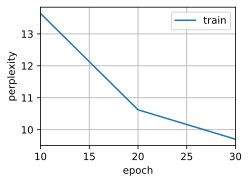

In [ ]:
num_epochs, lr = 30, 0
print(d2l.try_gpu())
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

[**最后，让我们检查一下使用随机抽样方法的结果。**]


困惑度 9.6, 16631.8 词元/秒 cpu
time travellere the the the the the the the the the the the the 
travellere the the the the the the the the the the the the 


9.648228933367063

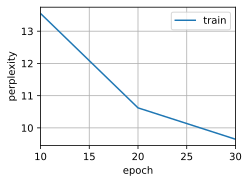

In [17]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

从零开始实现上述循环神经网络模型，
虽然有指导意义，但是并不方便。
在下一节中，我们将学习如何改进循环神经网络模型。
例如，如何使其实现地更容易，且运行速度更快。

## 小结

* 我们可以训练一个基于循环神经网络的字符级语言模型，根据用户提供的文本的前缀生成后续文本。
* 一个简单的循环神经网络语言模型包括输入编码、循环神经网络模型和输出生成。
* 循环神经网络模型在训练以前需要初始化状态，不过随机抽样和顺序划分使用初始化方法不同。
* 当使用顺序划分时，我们需要分离梯度以减少计算量。
* 在进行任何预测之前，模型通过预热期进行自我更新（例如，获得比初始值更好的隐状态）。
* 梯度裁剪可以防止梯度爆炸，但不能应对梯度消失。

## 练习

1. 尝试说明独热编码等价于为每个对象选择不同的嵌入表示。
1. 通过调整超参数（如迭代周期数、隐藏单元数、小批量数据的时间步数、学习率等）来改善困惑度。
    * 困惑度可以降到多少？
    * 用可学习的嵌入表示替换独热编码，是否会带来更好的表现？
    * 如果用H.G.Wells的其他书作为数据集时效果如何，
      例如[*世界大战*](http://www.gutenberg.org/ebooks/36)？
1. 修改预测函数，例如使用采样，而不是选择最有可能的下一个字符。
    * 会发生什么？
    * 调整模型使之偏向更可能的输出，例如，当$\alpha > 1$，从$q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1)^\alpha$中采样。
1. 在不裁剪梯度的情况下运行本节中的代码会发生什么？
1. 更改顺序划分，使其不会从计算图中分离隐状态。运行时间会有变化吗？困惑度呢？
1. 用ReLU替换本节中使用的激活函数，并重复本节中的实验。我们还需要梯度裁剪吗？为什么？


[Discussions](https://discuss.d2l.ai/t/2103)



my answer is:
   4) 在不裁剪梯度的情况下，会出现数值不稳定的现象。表现是 perplexity 完全不收敛了，来回震荡
   5) unknown
   6) unknown

困惑度 9.0, 17871.4 词元/秒 cpu
time travellere the and and and and and and and and and and and 
travellere the and and and and and and and and and and and 
hyper[1]:9.0


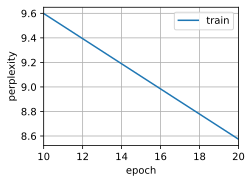

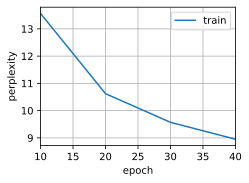

In [18]:
# [迭代周期，隐藏单元数，批量大小，小批量数据时间步数，学习率]
hyper_1 = [20, 512, 35, 10, 1]
hyper_2 = [40, 512, 35, 32, 1]
hyper_params = [hyper_1, hyper_2]

perplexity = []
for i in range(len(hyper_params)):
    num_epochs, num_hiddens, batch_size, num_steps, lr = hyper_params[i]
    train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
    net = d2l.RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
    value = round(train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu()), 1)
    perplexity.append(value)
    print("hyper[%d]:%.1f" % (i, perplexity[i]))